In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#import pkg that distribute sectos (BEN/MCTI/IPCC) to activities (IBGE)
#! pip install BenToTru==0.0.27
from BenToTru import btt as btt


#instalar pkg that contains MCTI data about emission
#! pip install sirene==0.0.6
from sirene import srn as srn

#instalar pkg that contains IBGE data about TRU
#! pip install iotbr==0.0.17
from iotbr import tru as tru

In [32]:
dict1 = btt.import_dictionaries('51')
# dict1[0] #ben_to_tru_products, 
# dict1[1] #ben_to_tru_sectors

# dados do ben
#btt.import_data_ben(year='2017',N = '51')

# Emissões setor Energia

## Conferir se os dados de emissões estimados (btt) estão similares aos dados oficiais (MCTI/SIRENE)

### criar dase de dados com as emissões estimadas (eCO2)

In [23]:
btt_68 = pd.DataFrame()
for i in range(2000,2021):
    try:
        i = str(i)
        sys_co2 = btt.emission(year = i, N = '68', gas='CO2',household=True)[4]
        sys_ch4 = btt.emission(year = i, N = '68', gas='CH4',household=True)[4]
        sys_n2o = btt.emission(year = i, N = '68', gas='N2O',household=True)[4]
        #sys_co2 = btt.system(i,'68','t','CO2',household = True).emission_tru_adjusted
        #sys_ch4 = btt.system(i,'68','t','CH4',household = True).emission_tru_adjusted
        #sys_n2o = btt.system(i,'68','t','N2O',household = True).emission_tru_adjusted
        CO2e_GWP_SAR = sys_co2 + (sys_ch4 * 21) + (sys_n2o * 310)
        CO2e_GWP_SAR['year'] = i
        btt_68 = pd.concat([btt_68, CO2e_GWP_SAR])
    except:
        print('error')

### Comparar dados MCTI/SIRENE com dados estimados (BTT)

In [25]:
#função para agregar dados de emissões do Sirene e do BenToTru
def grap1(df, sirene_ghg, sirene_sector, btt_activities):
  #import data from sirene
  srn_e = srn.read('energia',sirene_ghg)
  srn_e_r = pd.DataFrame(srn_e[srn_e.index.isin(sirene_sector)].sum(axis=0)).T
  #srn_e_r = srn_e.filter(like= sirene_sector, axis=0)
  srn_e_r = srn_e_r.T.loc[2000.0:2020.0,:]
  srn_e_r.columns = ['ghg']
  srn_e_r['ghg']

  #data from BenToTru
  df_ = df.drop(columns=['ELETRICIDADE']) #exclude the good 'eletricity' from the analisis
  df_ = df_.iloc[:, :-1].sum(axis=1) #agregate emissions of all goods
  df_ = pd.DataFrame(df_)
  df_['year'] = df['year']
  df_.columns = ['btt','year']
  df_r = df_.loc[btt_activities] #select a specific activities
  df_r = df_r.groupby('year')['btt'].sum().reset_index() #agregat activities into sector
  df_r.index = df_r['year'].astype(float)
  df_r = df_r.loc[2000:2020,:]
  df_r['sirene'] = srn_e_r['ghg'] #combine emission frm sirene and btt
  df_r['coef'] = df_r['sirene'] / df_r['btt'] #estimate coefficiente between series
  return df_r

import matplotlib.pyplot as plt
def plot12(df_r, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(df_r['btt'], label='btt', marker='o')
    ax.plot(df_r['sirene'], label='sirene', marker='o')
    ax.set_title(title)
    ax.set_xlabel('Year')
    ax.set_ylabel('Gg of CO2e_GWP_SAR')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    return fig

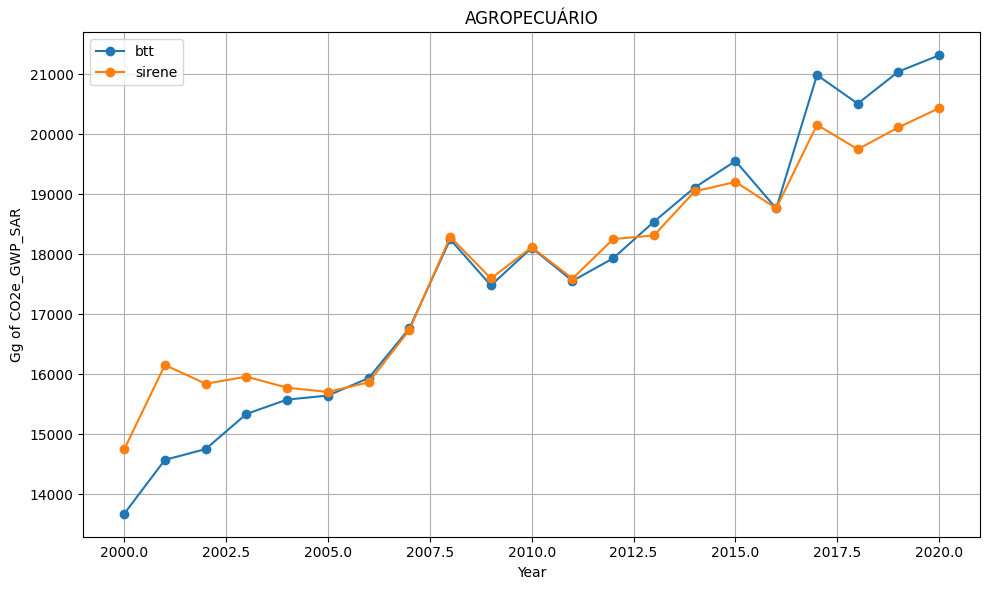

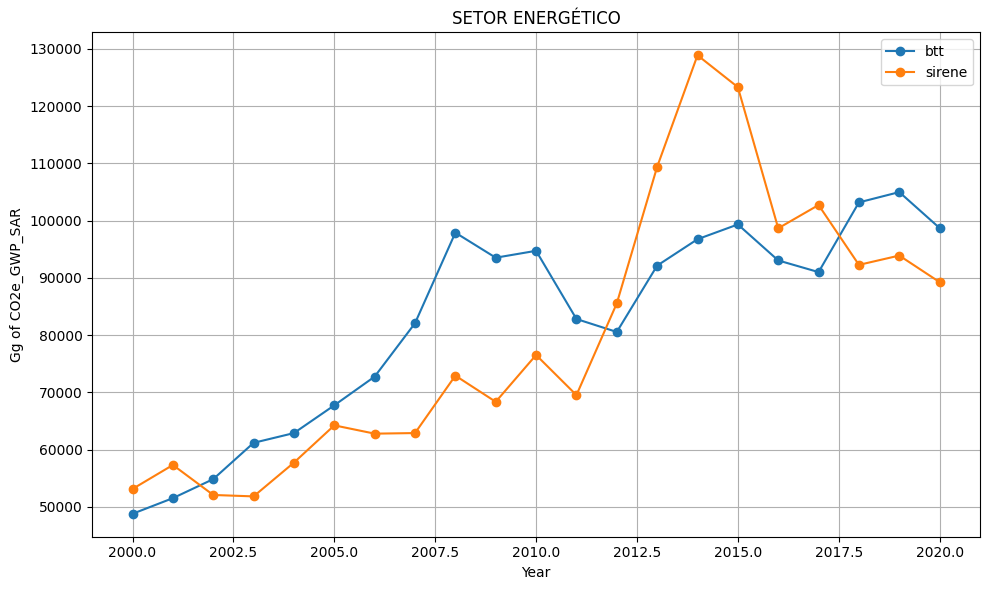

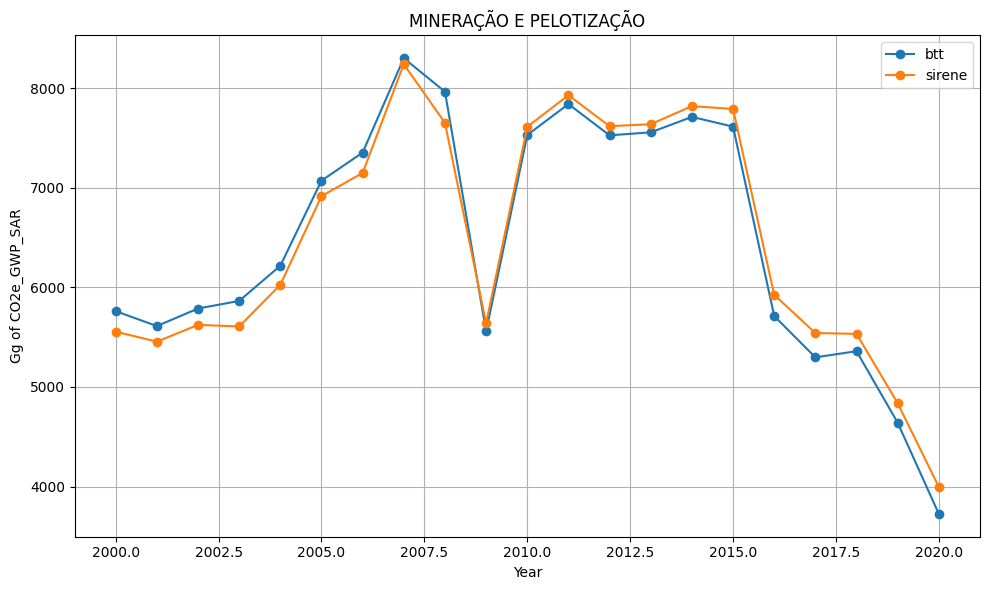

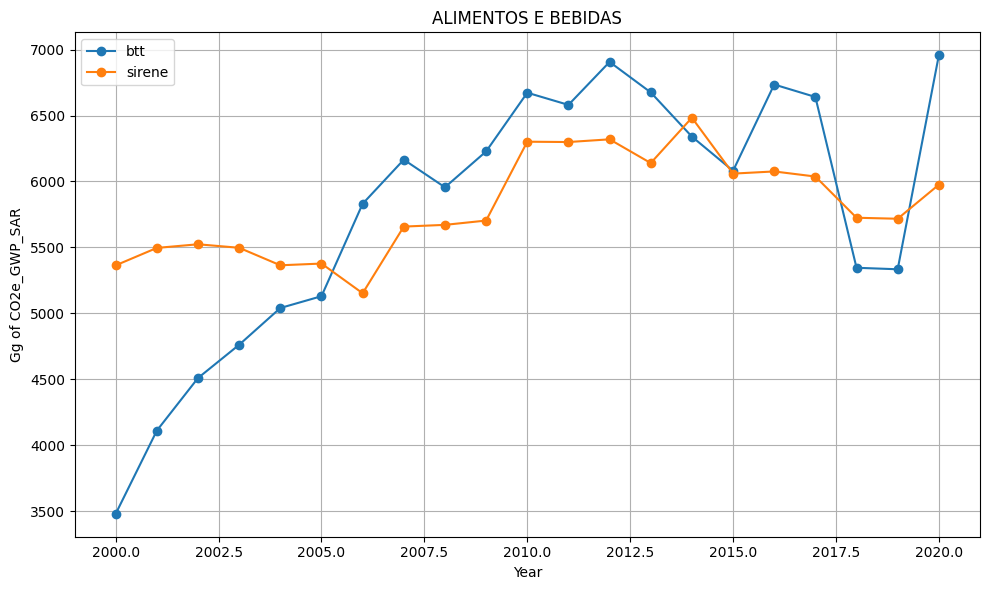

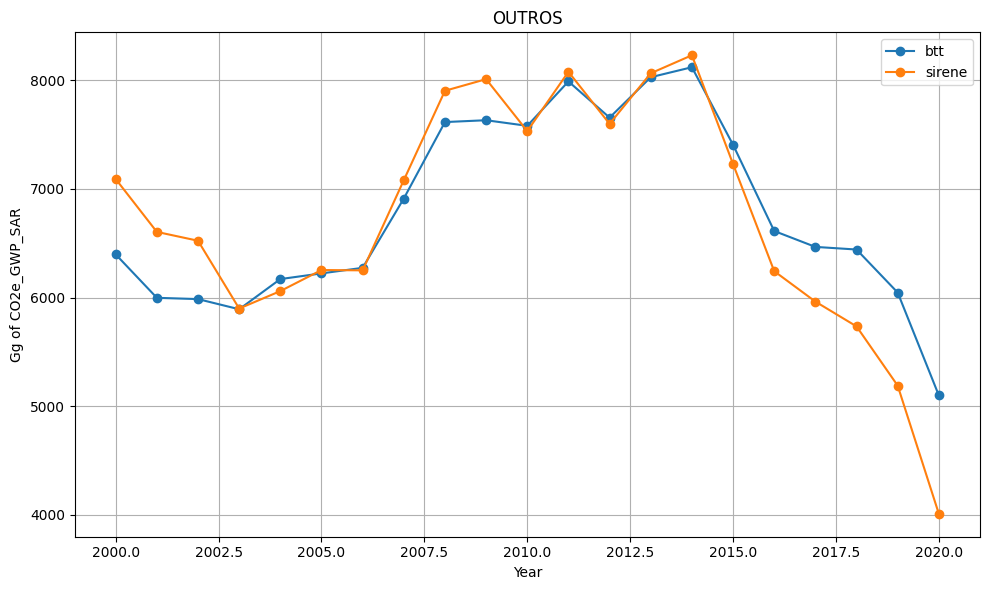

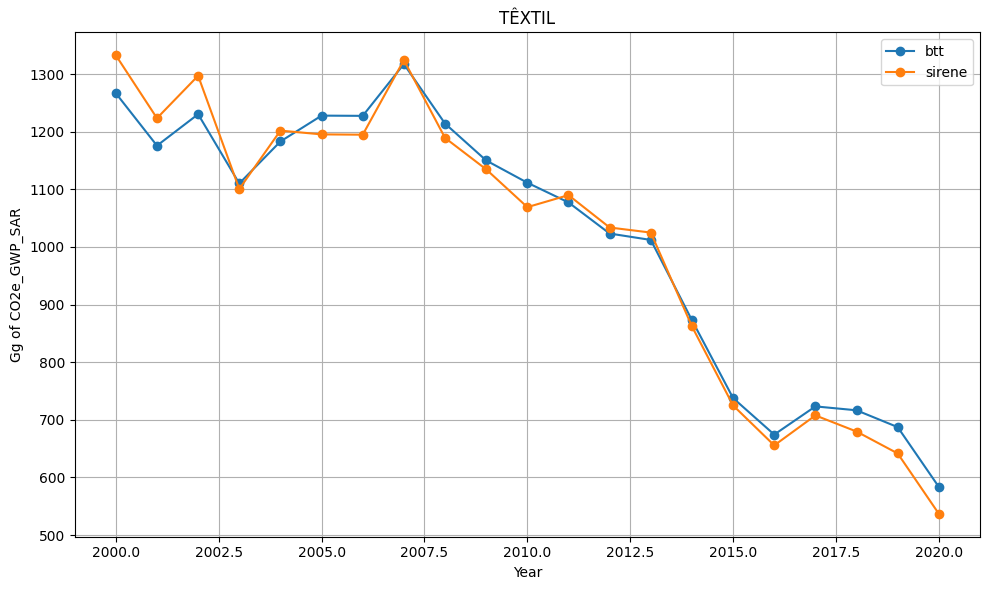

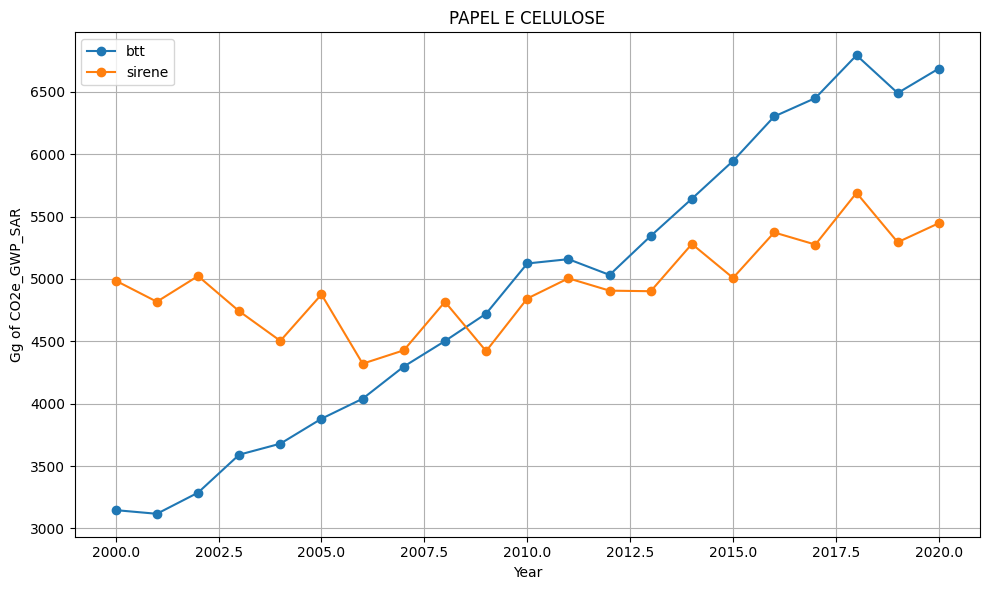

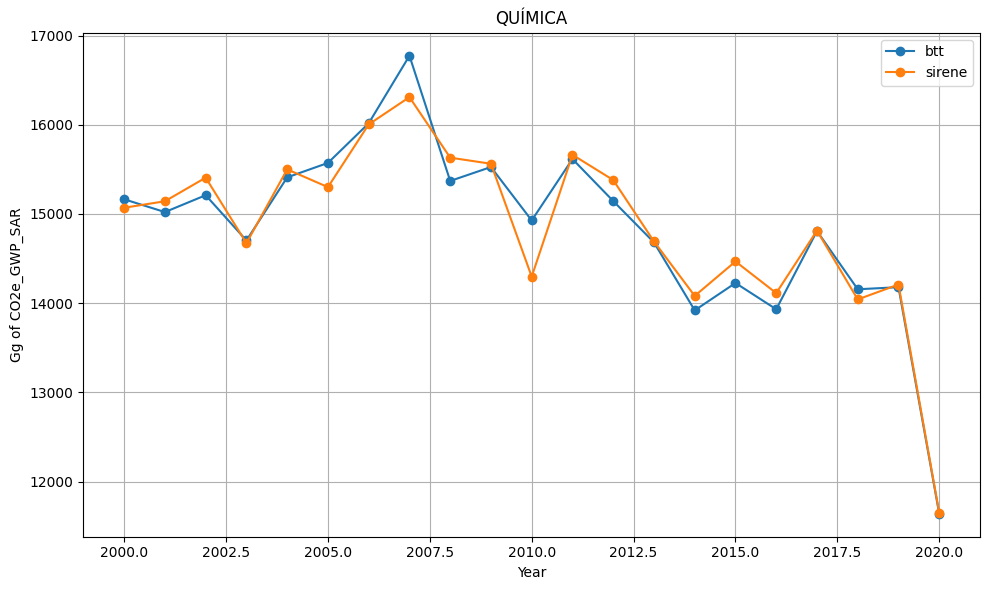

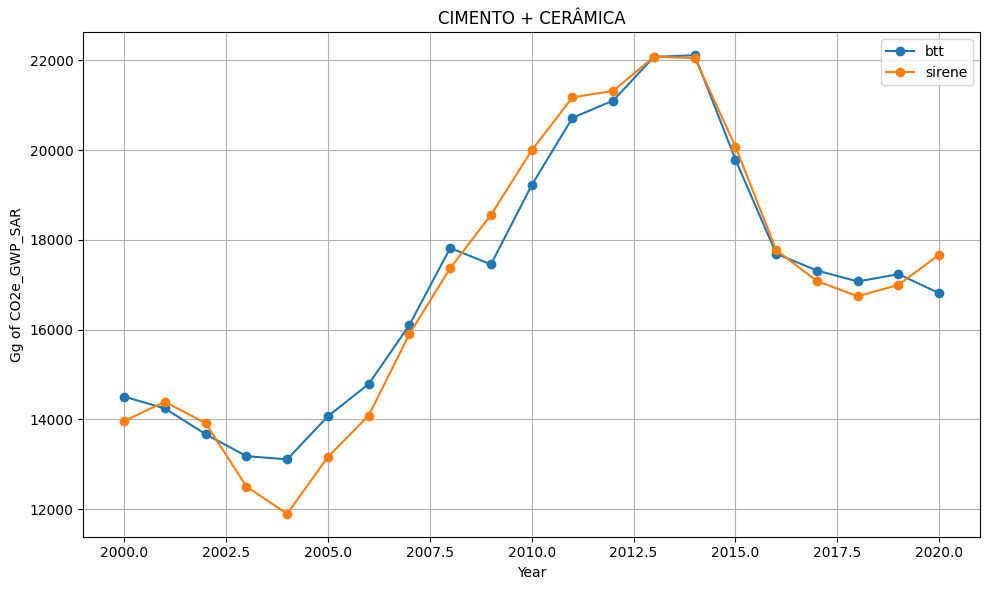

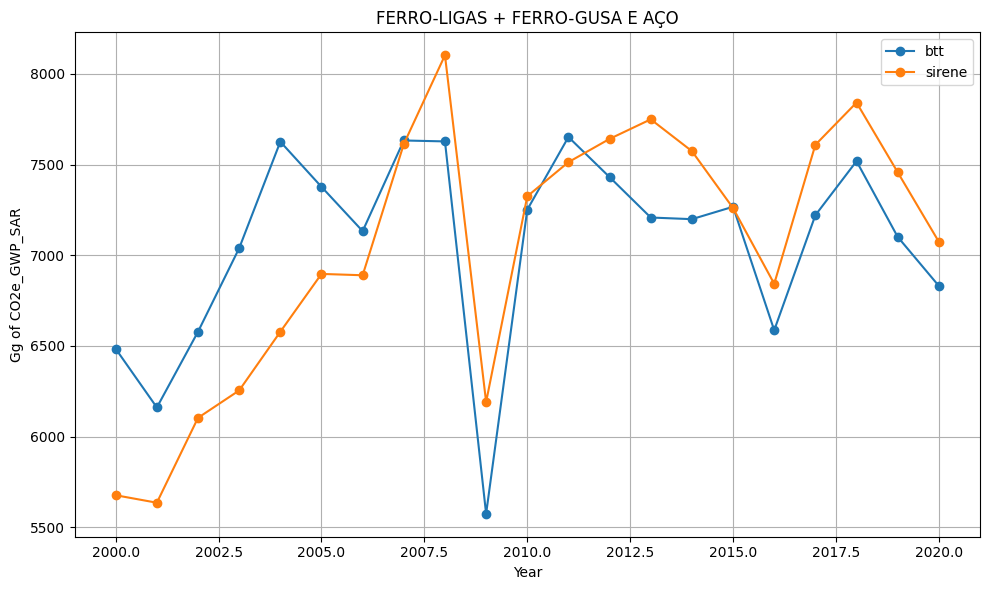

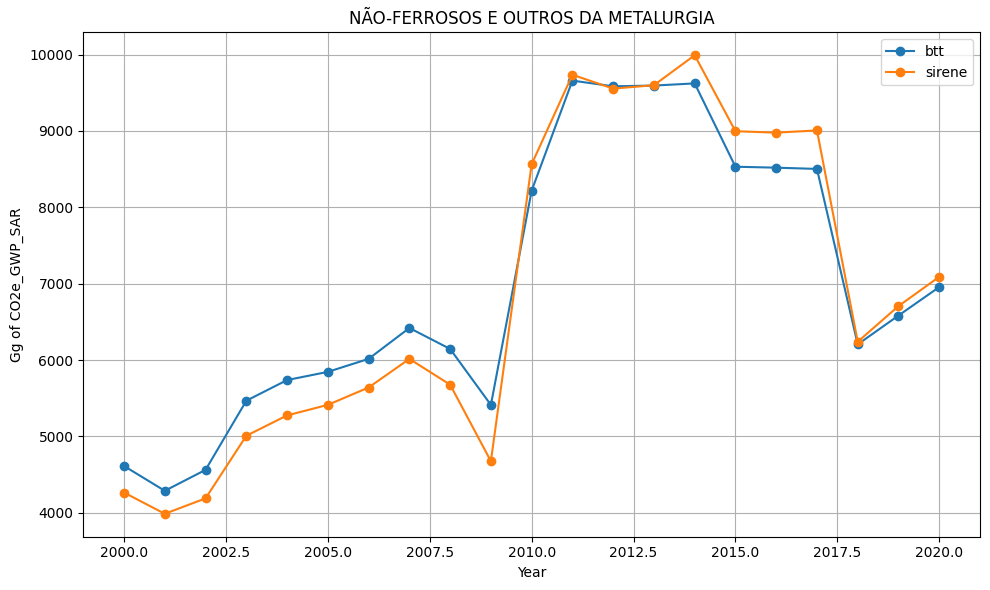

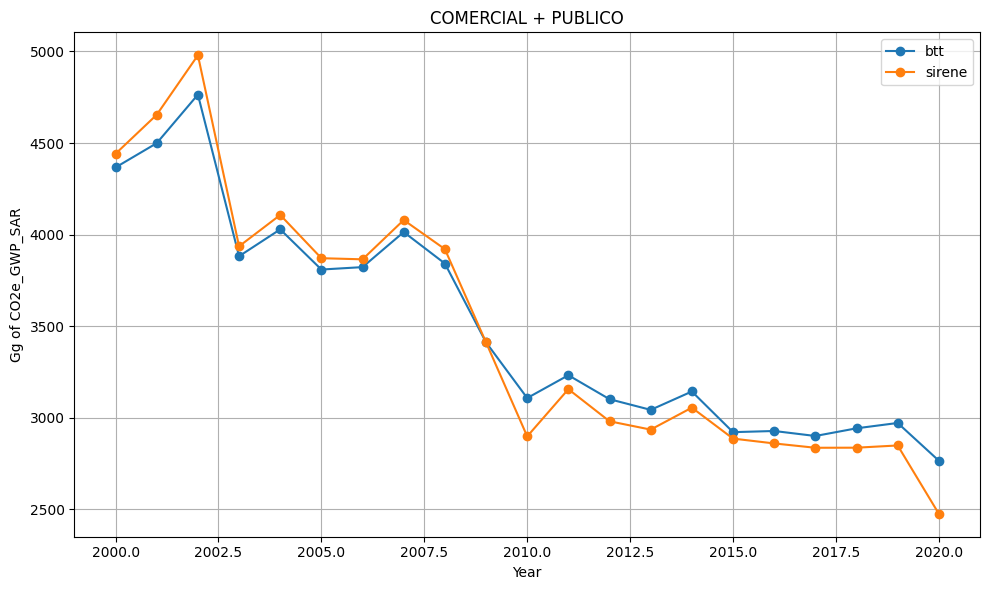

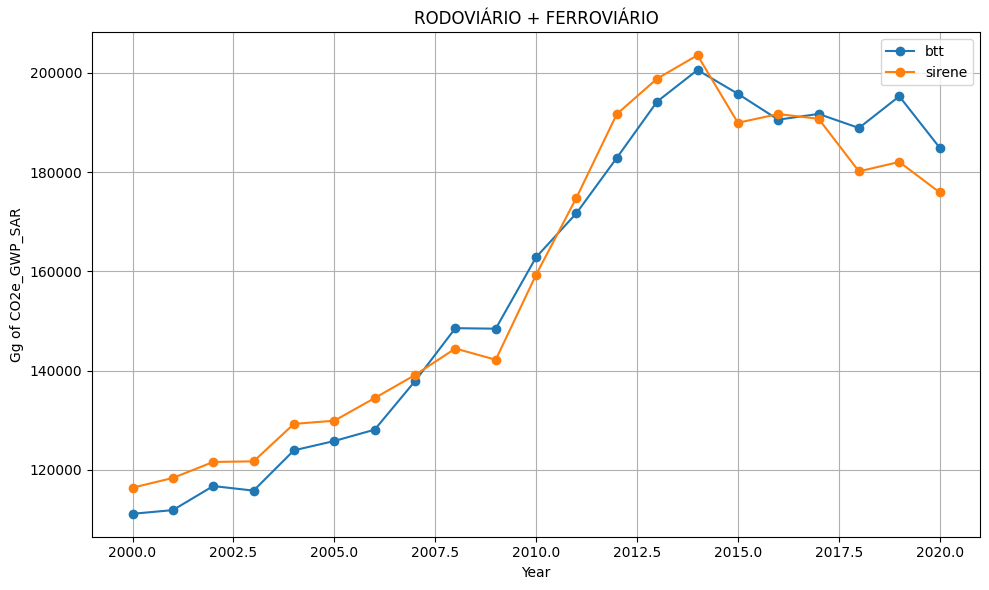

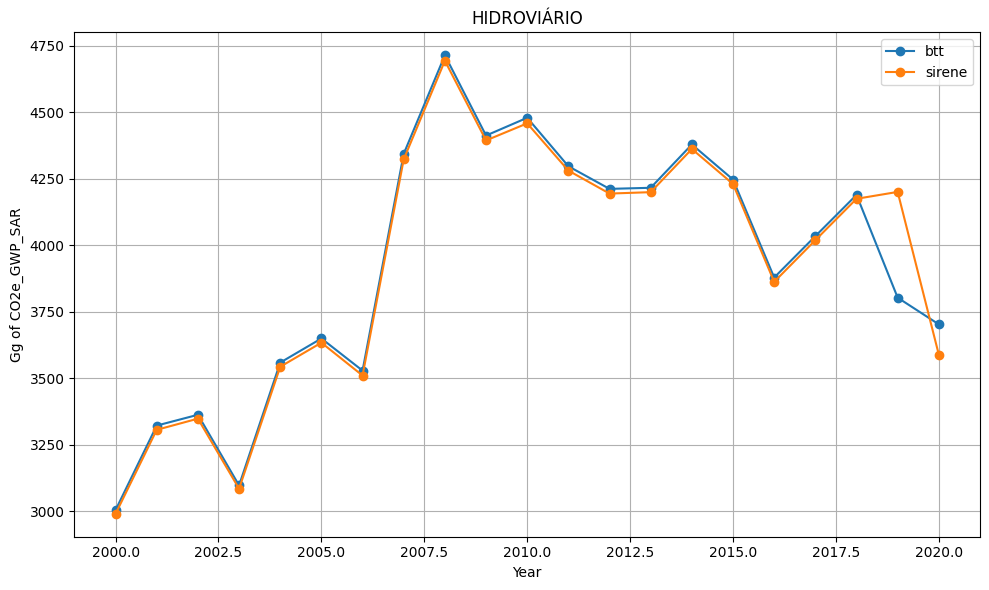

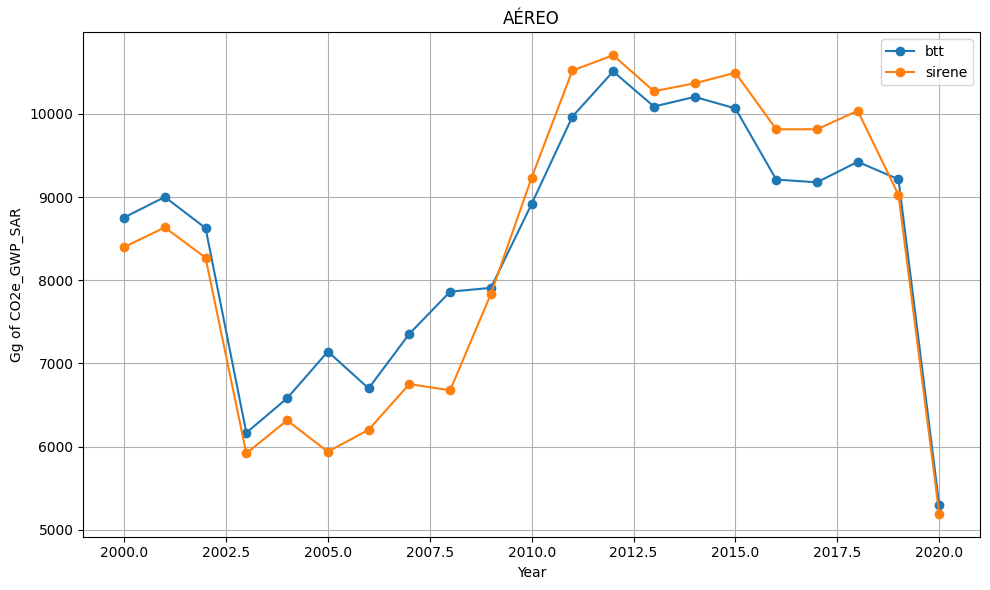

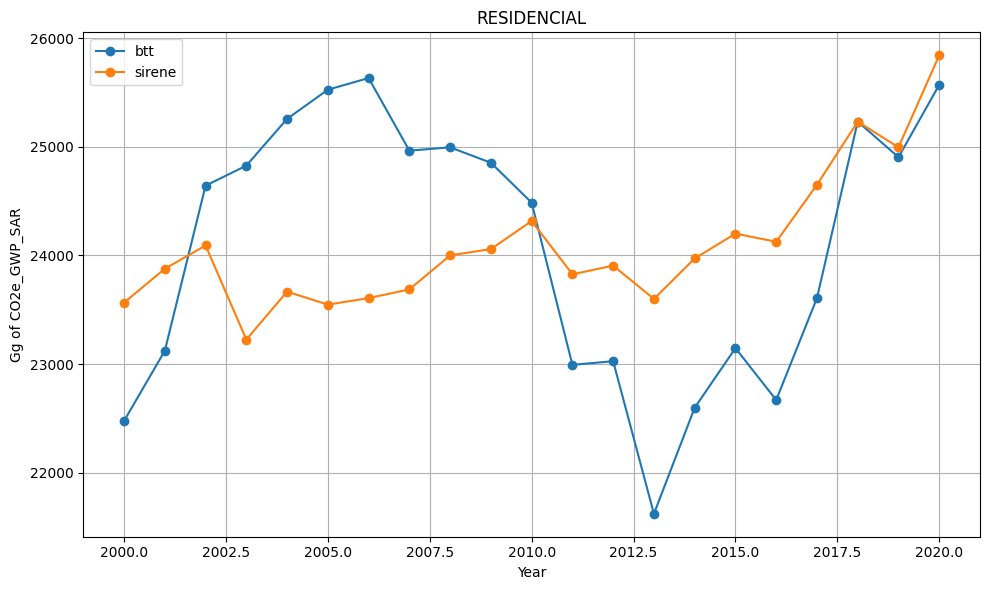

In [26]:
#import data from sirene
dict1 = pd.read_csv('https://raw.githubusercontent.com/fms-1988/datas/main/setores_ipcc_ben.csv')
sys = btt.emission(year = '2011', N ='68', gas='CO2',household=True)#('2011','68','t','CO2')
emission_tru = sys[0]

#map_ben_to_tru('68',ben_to_tru_sectors,matrix,sector_ben_index=1,product_ben_index=1)

#create charts
figure_list = []
df_results = pd.DataFrame({'sector': [],'correlation': [],'slope':[]})
for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, '11 + 12', 13, 14, 15, 'RESIDENCIAL']:#ben sectors
  #define variables
  sirene_sector = dict1[dict1['sector_ben_68_line']==str(i)]['sector_ipcc'].values#[0]
  btt_sector = dict1[dict1['sector_ben_68_line']==str(i)]['setor_ben'].values[0]
  sirene_ghg = 'CO2e_GWP_SAR'
  if i == 'RESIDENCIAL':
    btt_activities = 'RESIDENCIAL'#btt.map_ben_to_tru(sys,sys.emission_tru,i,0)[0].index
  elif i == '11 + 12':
    set1 = btt.map_ben_to_tru('68',emission_tru,11,0)[0].index
    set2 = btt.map_ben_to_tru('68',emission_tru,12,0)[0].index
    btt_activities = set1.union(set2)
  else:
    btt_activities = btt.map_ben_to_tru('68',emission_tru,i,0)[0].index

  #create database
  #print(btt_activities)
  df_r = grap1(btt_68, sirene_ghg, sirene_sector, btt_activities)

  #create charts to represent data
  fig = plot12(df_r, btt_sector)
  figure_list.append(fig)

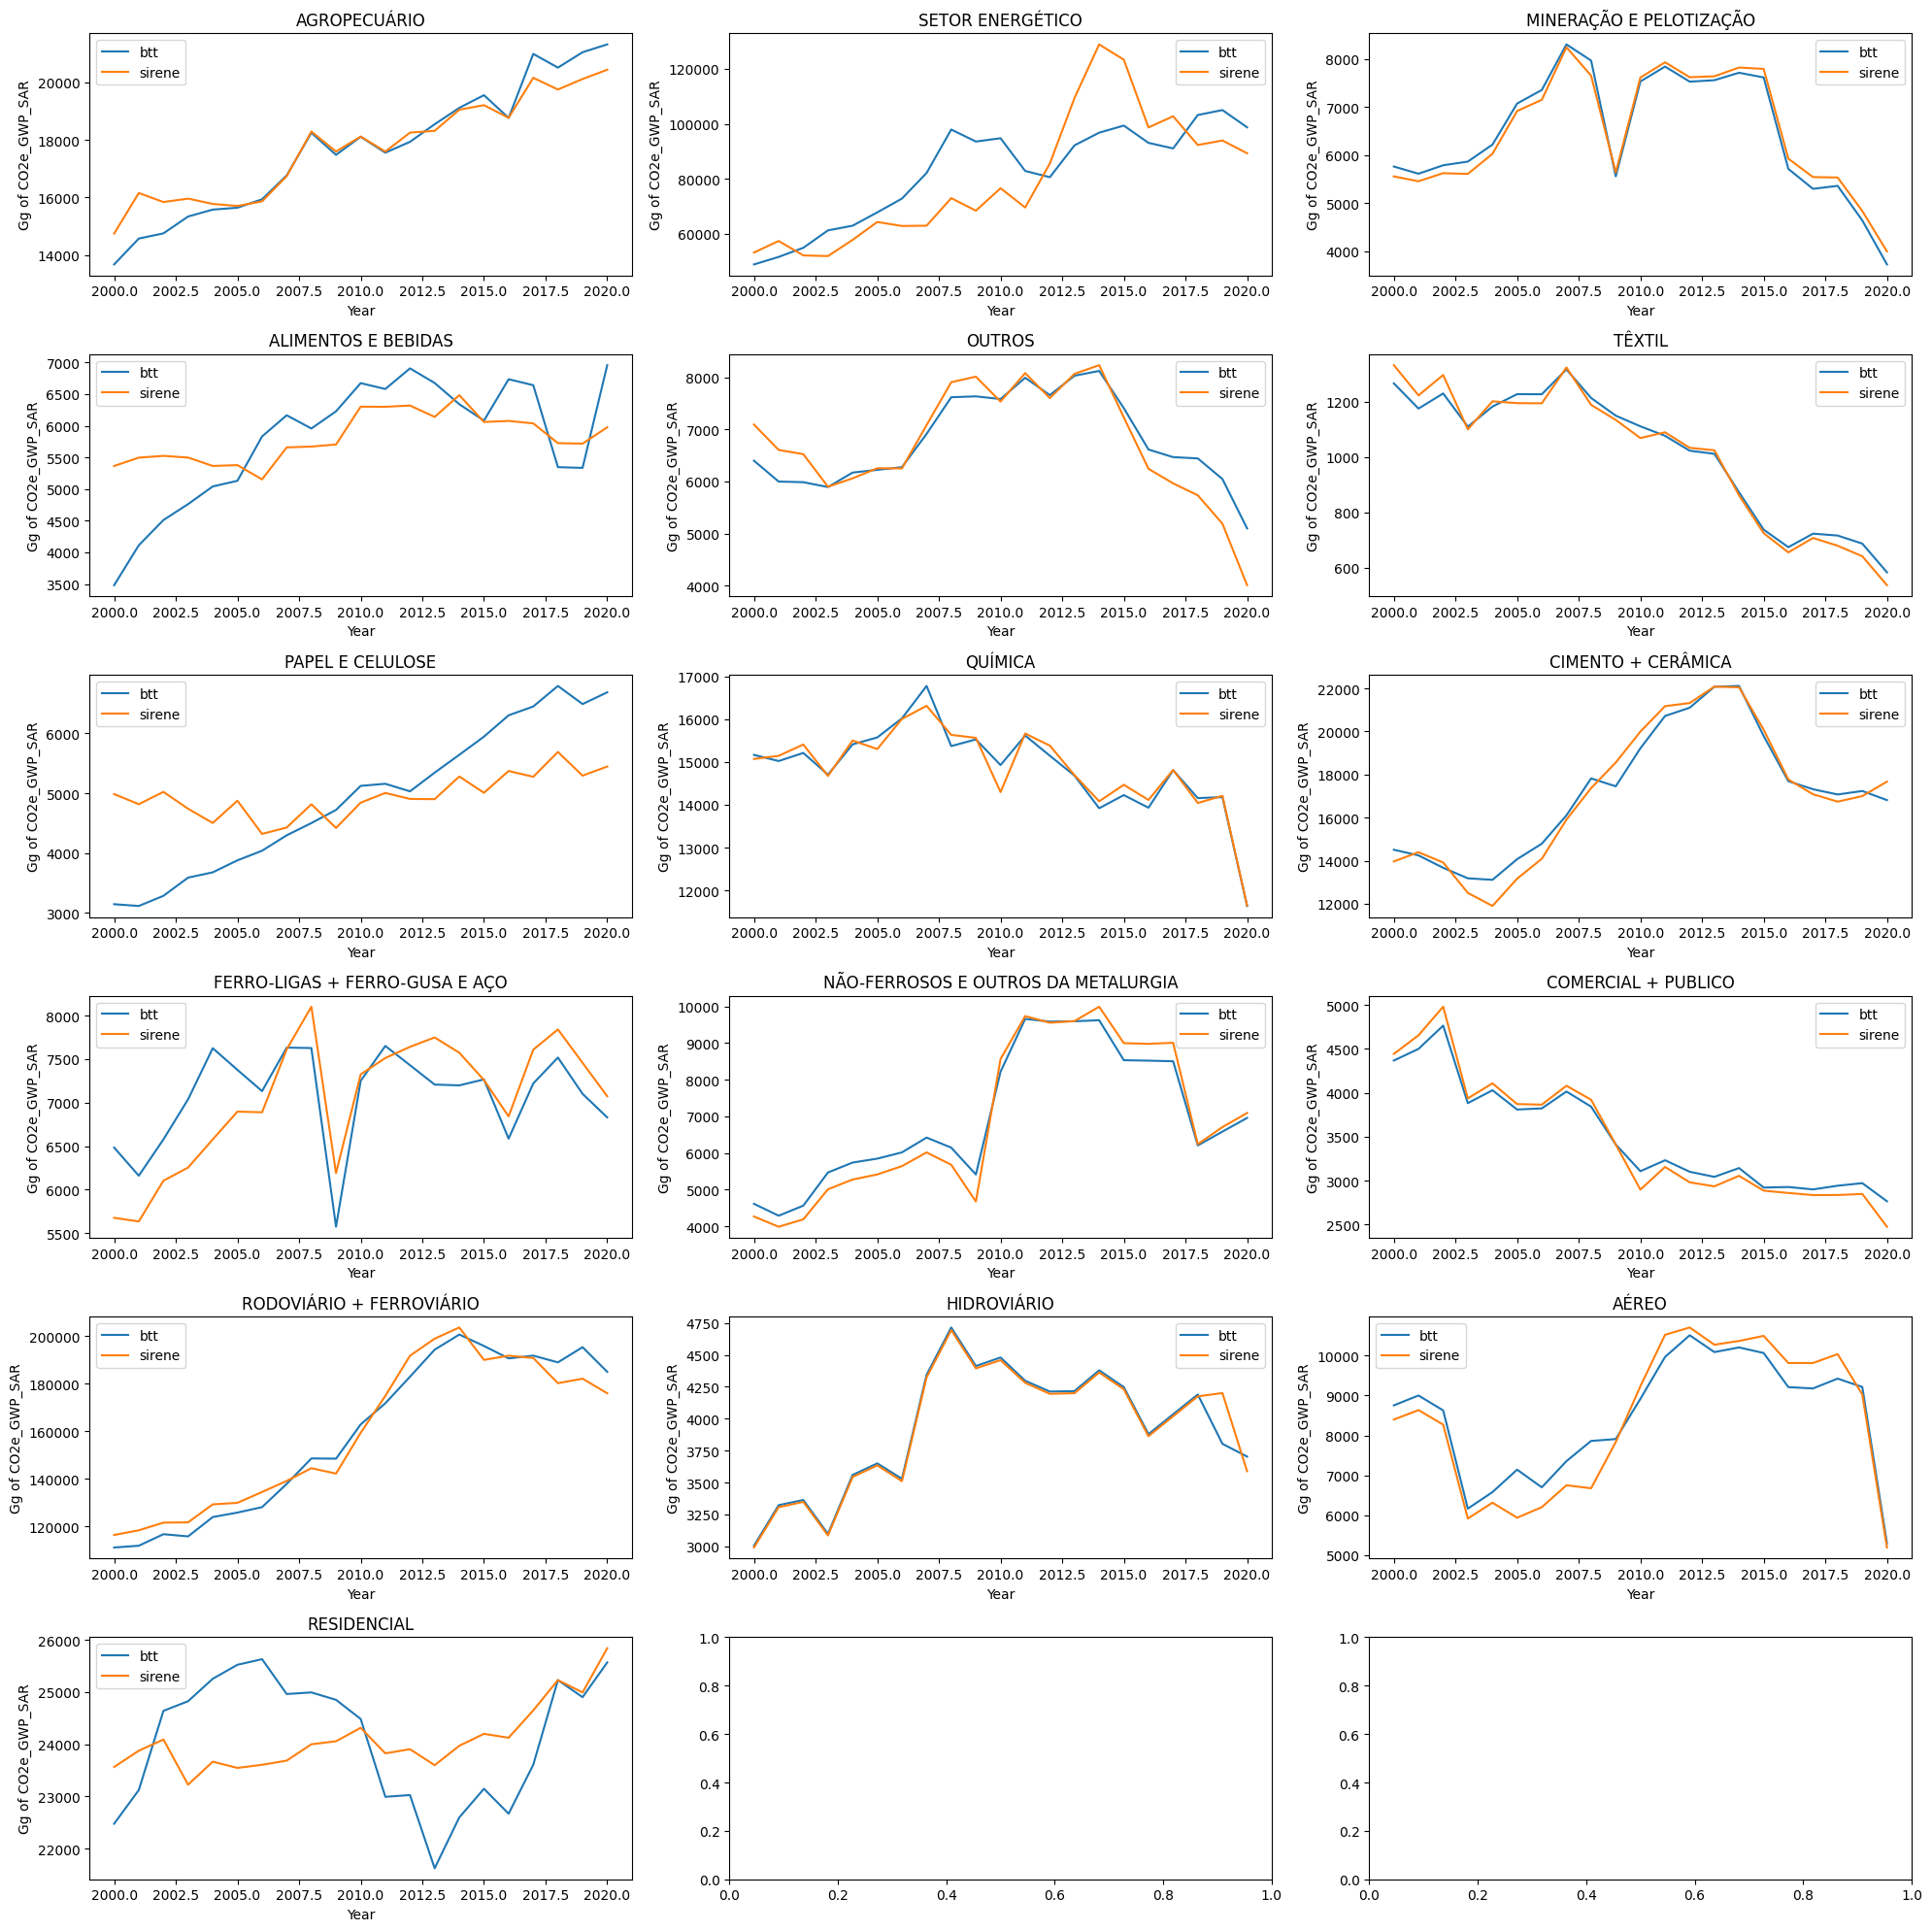

In [27]:
# Assuming you want rows x cols total plots
rows = 6
cols = 3

# Create a new figure for the combined subplots
combined_fig, axs = plt.subplots(rows, cols, figsize=(20, 20))

for i, fig in enumerate(figure_list):
    # Get the original Axes from the figure in the list
    old_ax = fig.axes[0]

    # Get the current subplot Axes
    ax = axs[i // cols, i % 3]

    # Transfer content (lines, labels, etc.) from old_ax to ax
    for line in old_ax.lines:
        ax.plot(line.get_xdata(), line.get_ydata(), label=line.get_label(), color=line.get_color())

    # Copy properties, such as title and labels
    ax.set_title(old_ax.get_title())
    ax.set_xlabel(old_ax.get_xlabel())
    ax.set_ylabel(old_ax.get_ylabel())
    ax.legend()

plt.tight_layout()
plt.show()

### Usar dados estimados (btt) para desagregar dados do MCTI/Sirene

In [29]:
#ajust emission to MCTI emission (68 activities)
#sys = btt.system('2010','68','t','CO2')#.emission_tru
sys = btt.emission(year = '2010', N = '68', gas='CO2',household=True)[4]
emission_tru_ajusted = sys.copy()
emission_tru_ajusted = pd.DataFrame(emission_tru_ajusted.sum(axis=1))
emission_tru_ajusted.columns = ['coef']
ben_sectors = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
for sec in ben_sectors:
  row_names = btt.map_ben_to_tru('68',emission_tru_ajusted,sec,0)[0].index
  total = emission_tru_ajusted.loc[row_names]['coef'].sum()
  emission_tru_ajusted.loc[row_names] /= total
emission_tru_ajusted.loc['RESIDENCIAL'] = 1
emission_tru_ajusted = emission_tru_ajusted.rename(index={'RESIDENCIAL': 'residencial'})
emission_tru_ajusted

,coef
"0191\nAgricultura, inclusive o apoio à agricultura e a pós-colheita",0.548239
"0192\nPecuária, inclusive o apoio à pecuária",0.283418
0280\nProdução florestal; pesca e aquicultura,0.168343
0580\nExtração de carvão mineral e de minerais não-metálicos,0.009940
"0680\nExtração de petróleo e gás, inclusive as atividades de apoio",0.024016
...,...
8692\nSaúde privada,0.041757
"9080\nAtividades artísticas, criativas e de espetáculos",0.016372
9480\nOrganizações associativas e outros serviços pessoais,0.078058
9700\nServiços domésticos,0.000000


In [30]:
#total emission by sector
energy_emission = srn.read('energia','CO2e_GWP_SAR')

#dictionary between sectos (MCTI) and sectors (BEN) (Bouth based on IPCC sectors)
dict1 = pd.read_csv('https://raw.githubusercontent.com/fms-1988/datas/main/setores_ipcc_ben.csv',sep=',')

energia_Gg_CO2e_GWP_SAR = pd.DataFrame()
for t in range(2000,2021):
  year = str(t)
  sys = btt.emission(year, N = '68', gas='CO2',household=True)[4]
  #sys = btt.system(year,'68','t','CO2')#.emission_tru
  btt_68_t = btt_68[btt_68.year==year].iloc[:,0:-1]#sys.emission_tru.copy()
  btt_68_t = pd.DataFrame(btt_68_t.sum(axis=1))
  btt_68_t.columns = ['energia_Gg_CO2e_GWP_SAR']
  ben_sectors = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  ipcc_sectors = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11 + 12', '11 + 12', '13', '14', '15']
  for sec_ben, sec_ipcc in zip(ben_sectors, ipcc_sectors):
    row_names = btt.map_ben_to_tru('68',sys,sec_ben,0)[0].index
    total = btt_68_t.loc[row_names]['energia_Gg_CO2e_GWP_SAR'].sum()
    btt_68_t.loc[row_names] /= total

    row_names2 = dict1[dict1['sector_ben_68_line']==sec_ipcc]['sector_ipcc']
    total2 = energy_emission.loc[row_names2][int(year)].sum()
    btt_68_t.loc[row_names] *= total2

  btt_68_t.loc['RESIDENCIAL'] = energy_emission.loc['1.A.4.b.       Residencial'].loc[int(year)]
  btt_68_t = btt_68_t.rename(index={'RESIDENCIAL': 'residencial'})
  #btt_68_t.index = [s.split('\n')[0] for s in btt_68_t.index]
  btt_68_t['year'] = t
  energia_Gg_CO2e_GWP_SAR = pd.concat([energia_Gg_CO2e_GWP_SAR,btt_68_t])

In [31]:
energia_Gg_CO2e_GWP_SAR#.index[energia_Gg_CO2e_GWP_SAR.index.str.contains('0192')]

,energia_Gg_CO2e_GWP_SAR,year
"0191\nAgricultura, inclusive o apoio à agricultura e a pós-colheita",8983.803199,2000
"0192\nPecuária, inclusive o apoio à pecuária",3902.606891,2000
0280\nProdução florestal; pesca e aquicultura,1856.822923,2000
0580\nExtração de carvão mineral e de minerais não-metálicos,1523.303921,2000
"0680\nExtração de petróleo e gás, inclusive as atividades de apoio",1532.903896,2000
...,...,...
8692\nSaúde privada,81.233978,2020
"9080\nAtividades artísticas, criativas e de espetáculos",44.906337,2020
9480\nOrganizações associativas e outros serviços pessoais,136.638012,2020
9700\nServiços domésticos,0.000000,2020


In [32]:
residuo_Gg_CO2e_GWP_SAR_TRU68 = pd.read_csv('https://raw.githubusercontent.com/fms-1988/datas/main/residuo_Gg_CO2e_GWP_SAR_TRU68.csv',sep=',')
residuo_Gg_CO2e_GWP_SAR_TRU68.columns = ['year','residencial','8691\nSaúde pública','8692\nSaúde privada','1091\nAbate e produtos de carne, inclusive os produtos do laticínio e da pesca','1100\nFabricação de bebidas',
                                         '1700\nFabricação de celulose, papel e produtos de papel','0192\nPecuária, inclusive o apoio à pecuária','residuo_Gg_CO2e_GWP_SAR_total']

residuo_Gg_CO2e_GWP_SAR_TRU68 = residuo_Gg_CO2e_GWP_SAR_TRU68.melt(id_vars=['year'], value_name='residuo_Gg_CO2e_GWP_SAR', var_name='index')
residuo_Gg_CO2e_GWP_SAR_TRU68 = residuo_Gg_CO2e_GWP_SAR_TRU68.set_index('index')
residuo_Gg_CO2e_GWP_SAR_TRU68#.index.unique()

,year,residuo_Gg_CO2e_GWP_SAR
index,,
residencial,1990,24870.457907
residencial,1991,26395.422552
residencial,1992,27226.703940
residencial,1993,29351.809030
residencial,1994,30919.239783
...,...,...
residuo_Gg_CO2e_GWP_SAR_total,2016,63292.233023
residuo_Gg_CO2e_GWP_SAR_total,2017,64424.565909
residuo_Gg_CO2e_GWP_SAR_total,2018,66661.377080
